In [15]:
# importing libraries
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from imblearn.combine import SMOTEENN

In [16]:
# load dataset
data = pd.read_csv("dataset/preprocessed.csv")

In [17]:
# load dataset to numpy
data_npWNan = data.iloc[:, :].values
tempNp = data_npWNan[data_npWNan[:, -1] != -1]
data_np = tempNp[:-2, :]

Frequency of unique values of the said array:
[[     1      2      3      4      5]
 [ 78815  87257 136412 183844 275764]]


In [ ]:
# showing frequency of targets
unique_elements, counts_elements = np.unique(data_np[:, -1], return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

In [18]:
# kd tree function which will split data according to features's covariance
def kd_tree(data, counter, arr):
    if counter == 1:
        arr.append(data)
    if counter > 0:
        covarr = data[:-1].var(axis = 0)
        maxelement = covarr.argmax(axis = 0) 
        data = data[data[:, maxelement].argsort()]
        half = int(len(data) / 2)
        kd_tree(data[: half], counter - 1, arr)
        kd_tree(data[half :], counter - 1, arr)
    
kdTreeArr = []
kd_tree(data_np, 2, kdTreeArr)

In [19]:
# network 
# cosine similarity can be implemented by dot product
from torch import nn
class Network(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()        
        # Inputs to hidden layer linear transformation 
        self.output = nn.Linear(input_dim, output_dim) 
    def forward(self, x):
        x = self.output(x)
        return x

In [20]:
# In order to use dot product we have to normalize train data
def normalize_encodings(encodings):
    ref_norms = np.linalg.norm(encodings, axis=0)
    return encodings / ref_norms

In [21]:
# select k neighbour which have larger similarity and vote them to predict
def select_k(similarity_mat, k_neighbour, train_label, true_label):
    truePred = 0
    for houseIndex in range(len(similarity_mat)):
        vote = train_label[similarity_mat[houseIndex][-1 * k_neighbour:]]
        pred = np.bincount(vote).argmax()
        if true_label[houseIndex] == pred:
            truePred += 1
    accur = truePred / len(true_label)
    return accur

In [22]:
# Find similarity with dot product
def similarity(X_test):
    X_test = X_test.astype('float32')
    X_test = torch.from_numpy(X_test)
    X_test = X_test.cuda()
    with torch.no_grad():
        out = knn(X_test)
    del X_test
    return out

In [23]:
# for all part of data calculate similarity
# use k fold cross validation to find number of k in k-nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import gc 

cvCount = 5
numberOfKTry = 5
accuracyCount = np.array([0.0] * numberOfKTry)
startK = 700
kUpgrade = 20
batchSize = 30
maxKCount = startK + numberOfKTry * kUpgrade

import datetime
a = datetime.datetime.now().replace(microsecond=0)


kdPartCount = 0
for kdTreePart in kdTreeArr:  # 4 tane
    kdPartCount +=1
    feature = kdTreePart[:, :-1]
    target = kdTreePart[:, -1]

    #part 0
    X_trainAndVal, X_test, y_trainAndVal, y_test = train_test_split(feature, target, test_size = 0.2, random_state = 0)
    sm = SMOTEENN(random_state = 27, n_jobs = -1)
    X_trainAndVal, y_trainAndVal = sm.fit_sample(X_trainAndVal, y_trainAndVal)
    c = datetime.datetime.now().replace(microsecond=0)
    # Feature Scaling
    sc = StandardScaler()
    
    cvCounter = 0
    for cv in range(cvCount):  # 10 tane
        cvCounter += 1        
        
        X_train, X_val, y_train, y_val = train_test_split(X_trainAndVal, y_trainAndVal, test_size = 0.2, random_state = 0)
        X_train = sc.fit_transform(X_train) 
        X_val = sc.transform(X_val)
        X_train = normalize_encodings(X_train)
        
        knn = Network(X_train.shape[1], X_train.shape[0])
        knn = knn.cuda()
        knn.weight = X_train.T
        
        len_val = len(X_val) // batchSize + 1
        val_index = 0
        
        batchCount = 0 
        
        for i in range(batchSize):  # 50 tane
            if(i == batchSize-1 and cv % 1 == 0):
                print("kdTree'nin ",kdPartCount,". partindasindasin, ",cv,". k fold partindasindasin ",i,". batchi yapiyorsun")
            batchCount +=1 
            
            
            xValBatch = X_val[val_index : val_index + len_val]
            yValBatch = y_val[val_index : val_index + len_val]
            out = similarity(xValBatch)
            
            index = 0
            out = out.cpu().detach().numpy()
            
            similarityMat = np.argpartition(out, -1 * maxKCount, axis = 1)[:, -1 * maxKCount:]
    
            for x in range(len(similarityMat)):       
                similarityMat[x] = similarityMat[x][np.argsort(out[x][similarityMat[x]])]
            
            for kTry in range(startK, numberOfKTry * kUpgrade + startK, kUpgrade):
                delta = select_k(similarityMat, kTry, y_train, yValBatch)
                accuracyCount[index] += delta
                index += 1
            val_index += len_val
            del out, xValBatch, yValBatch, similarityMat
            torch.cuda.empty_cache()
            gc.collect()
            
        del X_train, X_val, y_train, y_val
        gc.collect()
    d = datetime.datetime.now().replace(microsecond=0)
    print("ara sure ",d - c)
        
    del X_trainAndVal, X_test, y_trainAndVal, y_test
    gc.collect()
    

(304836, 43)
Frequency of unique values of the said array:
[[     1      2      3      4      5]
 [ 24777  34122  55778  70885 119274]]
(266099, 43)
Frequency of unique values of the said array:
[[    1     2     3     4     5]
 [76931 53964 40850 39622 54732]]
kdTree'nin  1 . partindasindasin,  0 . k fold partindasindasin  29 . batchi yapiyorsun
kdTree'nin  1 . partindasindasin,  1 . k fold partindasindasin  29 . batchi yapiyorsun
kdTree'nin  1 . partindasindasin,  2 . k fold partindasindasin  29 . batchi yapiyorsun
kdTree'nin  1 . partindasindasin,  3 . k fold partindasindasin  29 . batchi yapiyorsun
kdTree'nin  1 . partindasindasin,  4 . k fold partindasindasin  29 . batchi yapiyorsun
ara sure  0:11:43
(304836, 43)
Frequency of unique values of the said array:
[[     1      2      3      4      5]
 [ 38280  35659  53286  76337 101274]]
(190304, 43)
Frequency of unique values of the said array:
[[    1     2     3     4     5]
 [55423 41136 30210 26809 36726]]
kdTree'nin  2 . partind

/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'k_neighbors' instead.
  category=DeprecationWarning)
/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'm' is deprecated from 0.2 and will be removed in 0.4. Use 'm_neighbors' instead.
  category=DeprecationWarning)
/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'k_neighbors' instead.
  category=DeprecationWarning)
/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'm' is deprecated from 0.2 and will be removed in 0.4. Use 'm_neighbors' instead.
  category=DeprecationWarning)


In [24]:
b = datetime.datetime.now().replace(microsecond=0)
print("son sure ",b-a)

son sure  0:18:11


In [25]:
accuracyCount /= (cvCount  * len(kdTreeArr) * batchSize)
bestKIndex = accuracyCount.argmax(axis=0) 
bestK = startK + bestKIndex * kUpgrade
print("en iyi k degeri ",bestK)

en iyi k degeri  780


In [26]:
print(accuracyCount)

[0.28924485 0.28925081 0.28919627 0.28922371 0.28928862]


In [ ]:
print("best accuracy ",max(accuracyCount))

In [27]:
kNumber = []
for kTry in range(startK, numberOfKTry * kUpgrade + startK, kUpgrade):
    kNumber.append(kTry)

700
720
740
760
780


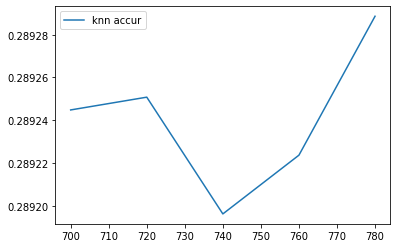

In [28]:
plt.plot(kNumber, accuracyCount, label = 'knn accur')
plt.legend()
plt.show()
